In [22]:
import wbgapi as wb
import wbdata
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import RANSACRegressor
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import r2_score


<h1 style="color:black; background-color:white; padding:10px; padding-bottom:10px;text-align: center;">To be rich or to be green</h1>

---

In [4]:
def load_and_name_db_WB(db, *args):
    global df_name
    df_name = db
    globals()[df_name] = wb.data.DataFrame(value1, wb.region.members(value2), range(value3, value4))
    globals()[df_name].columns = new_column_names
    return globals()[df_name]

In [5]:
value1 = ['EN.ATM.CO2E.PC','SL.GDP.PCAP.EM.KD']
new_column_names = ['CO2_per_capita', "GDP_per_capita"]
value2 = "WLD"
value3 = 2019
value4 = 2020

load_and_name_db_WB("df_original", value1, value2, value3, value4, new_column_names)

CO2_per_capita  GDP_per_capita
economy                                
ABW                 NaN             NaN
AFG            0.160850     8842.504595
AGO            0.779292    17314.051641
ALB            1.691968    30717.371022
AND            6.573595             NaN
...                 ...             ...
XKX                 NaN             NaN
YEM            0.351701             NaN
ZAF            7.568640    44759.518380
ZMB            0.370170    10726.750223
ZWE            0.765887     6177.275282

[217 rows x 2 columns]

In [23]:
def plot_ransac_regression(db_name, start_year, end_year):
    num_years = end_year - start_year + 1
    num_rows = (num_years - 1) // 3 + 1
    num_cols = min(num_years, 3)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    fig.tight_layout(pad=5.0)
    
    for year in range(start_year, end_year + 1):
        data = db_name.dropna()
        
        # Check if data contains at least one valid data point
        if data.shape[0] > 0:
            # Fit RANSACRegressor
            ransac = RANSACRegressor()
            ransac.fit(data[['CO2_per_capita']], data['GDP_per_capita'])
            
            # Obtain inlier and outlier mask
            inlier_mask = ransac.inlier_mask_
            outlier_mask = np.logical_not(inlier_mask)
            
            # Extract inlier and outlier data points
            inliers = data[inlier_mask]
            outliers = data[outlier_mask]
            
            # Calculate R-squared score
            r2 = ransac.score(data[['CO2_per_capita']], data['GDP_per_capita'])
            
            # Plot data points, regression line, and annotate R-squared score
            row = (year - start_year) // 3
            col = (year - start_year) % 3
            ax = axes[row, col] if num_rows > 1 else axes[col]
            ax.scatter(data['CO2_per_capita'], data['GDP_per_capita'], color='blue', label='Data Points')
            ax.scatter(outliers['CO2_per_capita'], outliers['GDP_per_capita'], color='red', label='Outliers')
            ax.plot(data['CO2_per_capita'], ransac.predict(data[['CO2_per_capita']]), color='green', label='RANSAC Regression Line')
            ax.set_xlabel('CO2_per_capita', fontsize=12)
            ax.set_ylabel('GDP_per_capita', fontsize=12)
            ax.set_title(f'RANSAC Regression {year}-{year+1}', fontsize=14)
            ax.annotate(f'R-squared = {r2:.2f}', xy=(0.5, 0.1), xycoords='axes fraction', fontsize=12)
            ax.legend(fontsize=12)
    
    plt.show()

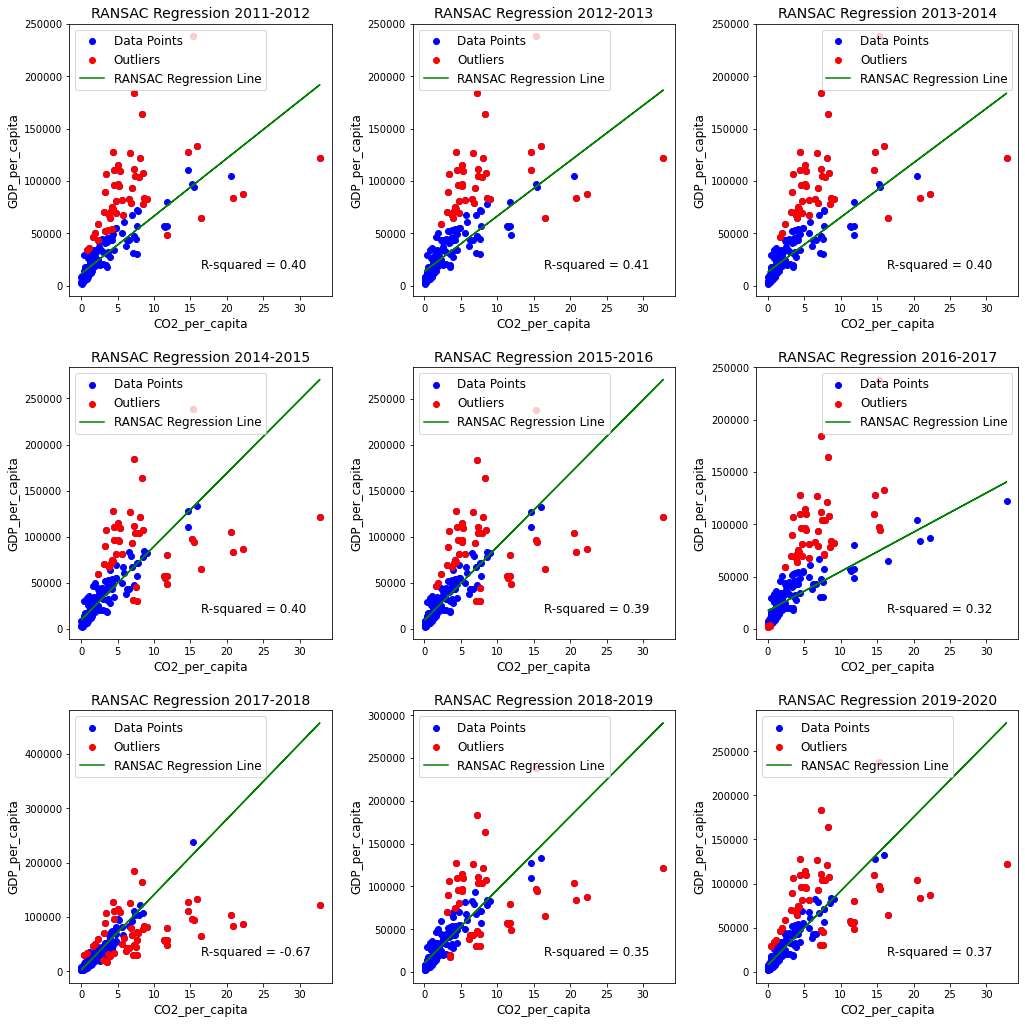

In [17]:
plot_ransac_regression(df_original, 2011, 2019)

In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor
from sklearn.metrics import r2_score
import statsmodels.api as sm

def plot_ransac_regression10(data, column1, column2):
    transformations = ['normal', 'log', 'sqrt', 'reciprocal']

    fig, axs = plt.subplots(3, 2, figsize=(14, 10))
    fig.tight_layout()

    for i, transformation in enumerate(transformations):
        # Apply data transformation
        if transformation == 'normal':
            transformed_x = data[column1]
            transformed_y = data[column2]
        elif transformation == 'log':
            transformed_x = np.log(data[column1])
            transformed_y = np.log(data[column2])
        elif transformation == 'sqrt':
            transformed_x = np.sqrt(data[column1])
            transformed_y = np.sqrt(data[column2])
        elif transformation == 'reciprocal':
            transformed_x = 1 / data[column1]
            transformed_y = 1 / data[column2]
        else:
            continue

        # Drop NaN values
        transformed_data = pd.DataFrame({'X': transformed_x, 'Y': transformed_y})
        transformed_data = transformed_data.dropna()

        # Fit a RANSACRegressor model to the transformed data
        ransac = RANSACRegressor()
        ransac.fit(transformed_data['X'].values.reshape(-1, 1), transformed_data['Y'].values)

        # Obtain the inlier and outlier mask
        inlier_mask = ransac.inlier_mask_
        outlier_mask = np.logical_not(inlier_mask)

        # Extract the inlier and outlier data points
        inliers_x = transformed_data['X'][inlier_mask]
        inliers_y = transformed_data['Y'][inlier_mask]
        outliers_x = transformed_data['X'][outlier_mask]
        outliers_y = transformed_data['Y'][outlier_mask]

        # Calculate the R-squared score for the regression line
        r2 = ransac.score(transformed_data['X'].values.reshape(-1, 1), transformed_data['Y'].values)

        # Visualize the data points, regression line, and annotate the R-squared score
        row = i // 2
        col = i % 2
        axs[row, col].scatter(transformed_x, transformed_y, color='blue', label='Data Points')
        axs[row, col].scatter(outliers_x, outliers_y, color='red', label='Outliers')
        axs[row, col].plot(transformed_data['X'].values.reshape(-1, 1), ransac.predict(transformed_data['X'].values.reshape(-1, 1)),
                           color='green', label='RANSAC Regression Line')
        axs[row, col].set_xlabel(column1 + ' (' + transformation + ' transformation)', fontsize=12)
        axs[row, col].set_ylabel(column2 + ' (' + transformation + ' transformation)', fontsize=12)
        axs[row, col].set_title('RANSAC Regression (' + transformation + ' transformation)', fontsize=14)
        axs[row, col].annotate(f'R-squared = {r2:.2f}', xy=(0.6, 0.1), xycoords='axes fraction', fontsize=12)
        axs[row, col].legend(fontsize=12)

    # Ordinary Least Squares (OLS)
    valid_mask = np.isfinite(data[column1]) & np.isfinite(data[column2])
    ols = sm.OLS(data[column2][valid_mask], sm.add_constant(data[column1][valid_mask])).fit()
    ols_pred = ols.predict(sm.add_constant(data[column1][valid_mask]))
    r2_ols = r2_score(data[column2][valid_mask], ols_pred)
    axs[2, 0].scatter(data[column1][valid_mask], data[column2][valid_mask], color='blue', label='Data Points')
    axs[2, 0].plot(data[column1][valid_mask], ols_pred, color='green', label='OLS Regression Line')
    axs[2, 0].set_xlabel(column1, fontsize=12)
    axs[2, 0].set_ylabel(column2, fontsize=12)
    axs[2, 0].set_title('Ordinary Least Squares (OLS) Regression', fontsize=14)
    axs[2, 0].annotate(f'R-squared = {r2_ols:.2f}', xy=(0.6, 0.8), xycoords='axes fraction', fontsize=12)
    axs[2, 0].legend(fontsize=12)

    # Weighted Least Squares (WLS)
    valid_mask = np.isfinite(data[column1]) & np.isfinite(data[column2])
    weights = 1 / np.abs(data[column1][valid_mask])  # Modify the weights calculation based on your needs
    wls = sm.WLS(data[column2][valid_mask], sm.add_constant(data[column1][valid_mask]), weights=weights).fit()
    wls_pred = wls.predict(sm.add_constant(data[column1][valid_mask]))
    r2_wls = r2_score(data[column2][valid_mask], wls_pred)
    axs[2, 1].scatter(data[column1][valid_mask], data[column2][valid_mask], color='blue', label='Data Points')
    axs[2, 1].plot(data[column1][valid_mask], wls_pred, color='green', label='WLS Regression Line')
    axs[2, 1].set_xlabel(column1, fontsize=12)
    axs[2, 1].set_ylabel(column2, fontsize=12)
    axs[2, 1].set_title('Weighted Least Squares (WLS) Regression', fontsize=14)
    axs[2, 1].annotate(f'R-squared = {r2_wls:.2f}', xy=(0.6, 0.1), xycoords='axes fraction', fontsize=12)
    axs[2, 1].legend(fontsize=12)

    plt.tight_layout()
    plt.show()


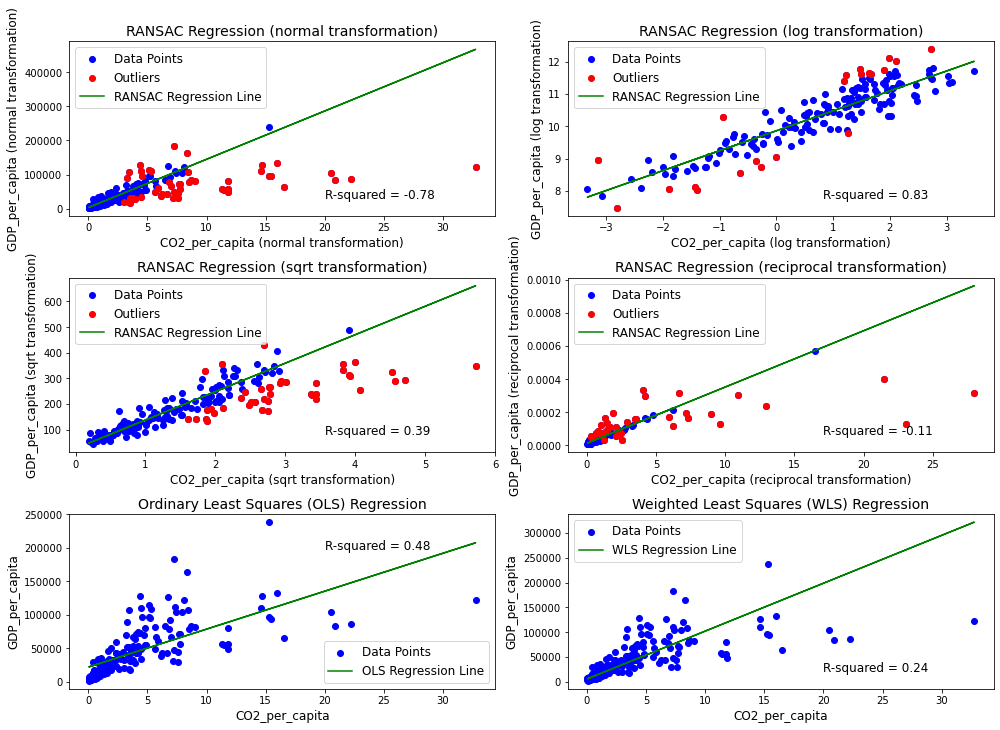

In [162]:
plot_ransac_regression10(df_original, "CO2_per_capita",	"GDP_per_capita")